In [291]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2
from scipy.fft import fft2, ifft2
from sklearn.cluster import KMeans

In [292]:
def read_raw(file_root='cube_20221028_104126\ENVI_cube_20221028_104126.raw'):
    """
    读取raw文件，转换成10*1024*1280的数组
    """
    width = 1280
    height = 1024
    channels = 10
    raw_image = np.fromfile(file_root, dtype=np.float16)
    image = raw_image.reshape((channels, height, width))
    image = image * 1.5e5
    
    return image 

In [293]:
def revise_raw(image):
    """
    将raw的值映射至1-7000，并让每个通道相加
    """
    image = image * 1e2
    image = np.sum(image, axis=0)
    
    return image

In [294]:
def show_heat_map(data = np.random.rand(1024, 1280), name='original'):
    """
    绘制热图,配置参数
    """
    
    # 定义自定义的颜色映射，从暗蓝色到绿色再到黄色，并反转颜色顺序
    cmap = ListedColormap(list(reversed(plt.cm.YlGnBu(np.linspace(0, 1, 256)))))
    # 绘制热图，并指定颜色映射和插值方式
    plt.imshow(data, cmap=cmap, interpolation='bilinear')
    plt.clim(0, 7000)
    # 添加颜色条
    plt.colorbar()

    # 添加标题和标签
    plt.title(name)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # 显示图像
    plt.show()
    

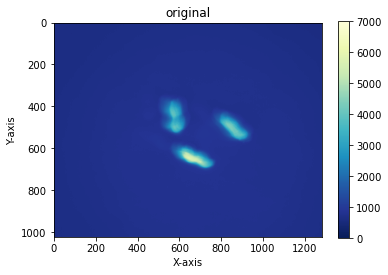

In [295]:
image = read_raw()
result = revise_raw(image)
show_heat_map(result)

In [296]:
def laplacian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels):
        blurred = cv2.pyrDown(pyramid[i])
        upscaled = cv2.pyrUp(blurred)
        height, width = pyramid[i].shape[:2]
        upscaled = cv2.resize(upscaled, (width, height))
        laplacian = cv2.subtract(pyramid[i], upscaled)
        pyramid.append(laplacian)
    return pyramid

In [297]:
def pixel_lignment(image):
    resized_data = image.astype(np.uint8)

    pyramids = []
    for i in range(len(resized_data)):
        pyramid = laplacian_pyramid(resized_data[i], levels=5)
        pyramids.append(pyramid)

    # 重建融合后的图像
    reconstructed_image = np.zeros_like(pyramids[0][-1])
    print(reconstructed_image.shape)
    for i in range(len(pyramids)):
        for j in range(len(pyramids[i])-1, 0, -1):
            expanded = cv2.pyrUp(pyramids[i][j])
            height, width = pyramids[i][j-1].shape[:2]
            expanded = cv2.resize(expanded, (width, height))
            reconstructed_image += expanded
        reconstructed_image += pyramids[i][0]
    reconstructed_image = reconstructed_image * 1e2
    
    return reconstructed_image

(1024, 1280)


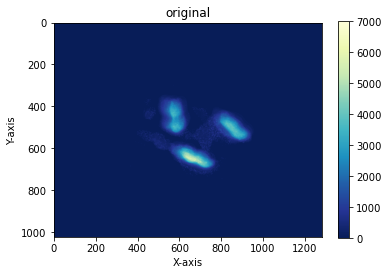

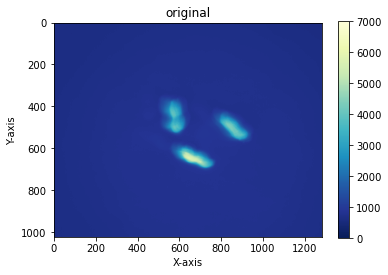

In [288]:
img = read_raw()
img = pixel_lignment(img)
show_heat_map(img)

show_heat_map(result)

## 评价指标使用不同通道的目标区域的平均面积重合度(mIOU)
### 1、计算所有通道的目标区域面积以及位置，目标区域指的是花生所在区域
### 2、选取基准通道，基准通道指目标区域面积最小的通道
### 3、计算所有通道与基准通道的IOU，之后求平均值，即为mIOU

In [200]:
def calculate_IOU(image1, image2):
    intersection = np.logical_and(image1, image2)
    union = np.logical_or(image1, image2)
    iou = np.sum(intersection) / np.sum(union)
    return iou


def calculate_mIOU(img):
    a = 1587120
    count = []
    img_lst = []
    for i, image in enumerate(img):
        # 将图像转换为二维数组
        pixels = image.reshape(1, -1)
        pixels = pixels.reshape(-1, 1)
        # 使用K均值聚类进行图像聚类
        kmeans = KMeans(n_clusters=2)  # K是聚类的数量
        kmeans.fit(pixels)
        # 获取聚类标签和聚类中心
        labels = kmeans.labels_
        
        # 将聚类结果转换为图像形式
        segmented_image = labels.reshape(1024, 1280)
        # 根据聚类结果标记多数类和少数类
        majority_class_label = np.argmax(np.bincount(labels))
        minority_class_label = 1 - majority_class_label
        segmented_image[segmented_image == majority_class_label] = 0
        segmented_image[segmented_image == minority_class_label] = 1
        
        img_lst.append(segmented_image)
        
        # 计算每个类别的个数
        counts = np.bincount(labels)
        count.append(min(counts))

    idx = count.index(min(count))
    IOU = 0
    for img in img_lst:
        IOU += calculate_IOU(img, img_lst[idx])
    return IOU/10

In [202]:
calculate_mIOU(image)

0.11747711181640626